In [37]:
!pip install tqdm

In [38]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from itertools import chain 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

In [39]:
import utils
from utils import KernelFunction, KernelEnvironment
from utils import plot_kernel_function, compare_kernels, train
from gflownet import GFlowNet 

## Testing Kernel Functions


In [40]:
k = KernelFunction()
print(k)
k1 = k.rbf(lengthscale=1.0)
print(k1)
k2 = k.linear(variances=0.5)
k3 = k1.add(k2).multiply(k.linear(variances=2.0))

print(k3)
# Output: ((RBF({'lengthscale': 1.0, 'variance': 1.0}) + Linear({'variances': 0.5})) * Linear({'variances': 2.0}))

None({})
RBF({'lengthscale': 1.0, 'variance': 1.0})
((RBF({'lengthscale': 1.0, 'variance': 1.0}) + Linear({'variances': 0.5})) * Linear({'variances': 2.0}))


In [41]:
# Step 1: Generate synthetic data
#np.random.seed(42)

# Inputs: 50 points in [0, 10]
X = np.linspace(0, 10, 50)[:, None]

# Ground-truth function: nonlinear + linear trend
Y_true = np.sin(X) + 0.5 * X
Y = Y_true + 0.3 * np.random.randn(*X.shape)  # add noise

# Step 2: Define composite kernel k3 = (RBF + Linear) * Linear
input_dim = X.shape[1]

# Step 3: Create and optimize GP model
real_k3 = k3.evaluate(input_dim=X.shape[1])
model = GPy.models.GPRegression(X, Y, kernel=real_k3)
model.optimize(messages=True)

# Print model info
print(model)

# Step 4: Predict and plot
Xtest = np.linspace(0, 10, 200)[:, None]
mean, var = model.predict(Xtest)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0005   1.732322e+01   6.048521e+01 
    00s11  0018   1.276376e+01   1.557729e-03 
    00s16  0025   1.274942e+01   1.048530e-02 
    00s19  0030   1.274875e+01   1.866841e-04 
    00s34  0083   1.274862e+01   8.334320e-07 
Runtime:     00s34
Optimization status: Converged


Name : GP regression
Objective : 12.748615312459808
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.            |                  value  |  constraints  |  priors
  mul.sum.rbf.variance      |      5.841528694049454  |      +ve      |        
  mul.sum.rbf.lengthscale   |     2.6865651201034475  |      +ve      |        
  mul.sum.linear.variances  |  5.404646479427418e-07  |      +ve      |        
  mul.linear.variances      |    0.07363361461932248  |      +ve      |        
  Gaussian_noise.variance   |    0.04842742961936531  |      +ve      |        

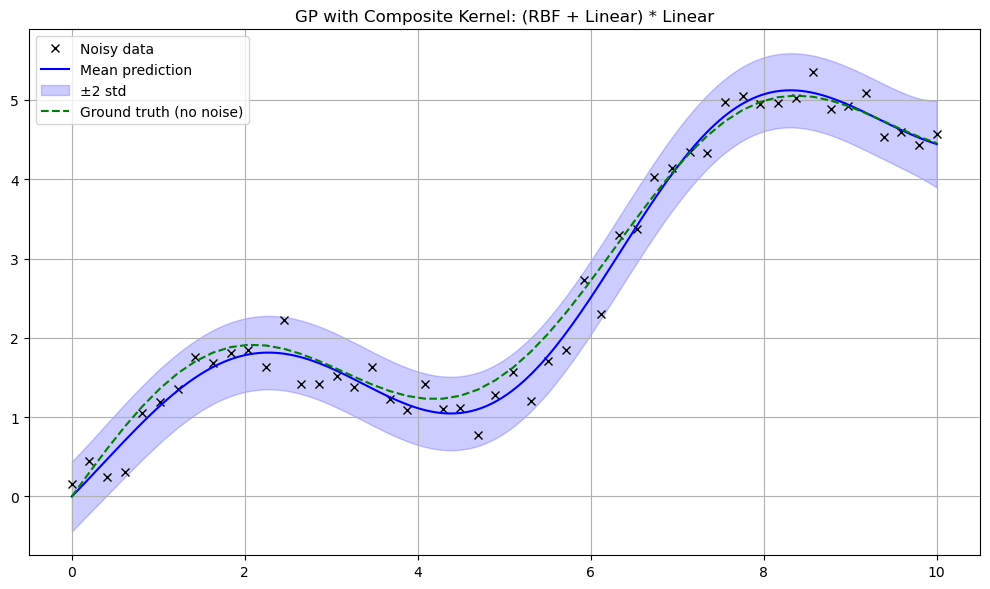

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(X, Y, "kx", label="Noisy data")
plt.plot(Xtest, mean, "b", label="Mean prediction")
plt.fill_between(Xtest.flatten(),
                 mean.flatten() - 2 * np.sqrt(var.flatten()),
                 mean.flatten() + 2 * np.sqrt(var.flatten()),
                 color="blue", alpha=0.2, label="±2 std")
plt.plot(X, Y_true, "g--", label="Ground truth (no noise)")
plt.title("GP with Composite Kernel: (RBF + Linear) * Linear")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Testing `generate_kernel`

In [43]:
true_kernel = KernelFunction().periodic(period=3.0, lengthscale=0.01).add(
    KernelFunction().linear(variances=0.1))
# generating synthetic data
X, Y, true_kernel_str = utils.generate_gp_data(true_kernel, input_dim=1, n_points=50, noise_var=1e-3)

print("True Kernel:", true_kernel_str)

True Kernel: (Periodic({'period': 3.0, 'variance': 1.0, 'lengthscale': 0.01}) + Linear({'variances': 0.1}))


In [44]:
# candidate kernel
candidate_kernel = KernelFunction().linear()

log_likelihood = utils.evaluate_likelihood(true_kernel, X, Y, runtime=False)
print("Log Marginal Likelihood (true kernel):", log_likelihood)
log_likelihood = utils.evaluate_likelihood(candidate_kernel, X, Y, runtime=False)
print("Log Marginal Likelihood (candidate kernel):", log_likelihood)

Log Marginal Likelihood (true kernel): 96.21071286179053
Log Marginal Likelihood (candidate kernel): 15.625010077616459


In [45]:
utils._likelihood_cache

{"(Periodic({'period': 3.0, 'variance': 1.0, 'lengthscale': 0.01}) + Linear({'variances': 0.1}))": 96.21071286179053,
 "Linear({'variances': 1.0})": 15.625010077616459,
 "RBF({'lengthscale': 0.001, 'variance': 1.0})": 20.98025359524128,
 "RBF({'lengthscale': 1.0, 'variance': 1.0})": 84.99424759293501,
 "Periodic({'period': 1.0, 'variance': 1.0, 'lengthscale': 1.0})": 20.45540923627303,
 "Constant({'variance': 1.0})": 21.156533138115346}

In [46]:
k1 = KernelFunction().linear(variances=1.0)
k2 = KernelFunction().rbf(lengthscale=0.001)

print(utils.evaluate_likelihood(k1, X, Y, runtime=False))
print(utils.evaluate_likelihood(k2, X, Y, runtime=False))

15.625010077616459
12.853278153517383


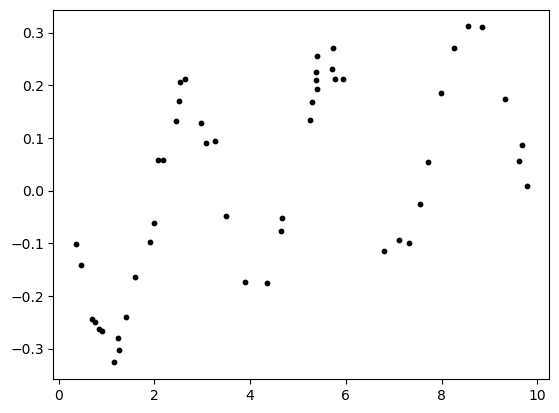

In [47]:
#plot the true kernel and candidate kernel and data points
plt.scatter(X, Y, color='black', s=10, label='Data Points')

## Testing Kernel Env

### Testing log likelihood reward

In [48]:
global reward_calls
reward_calls = 0

def log_likelihood_reward(X, Y, env: 'KernelEnvironment'):
    """
    Computes the log marginal likelihood of each kernel in the environment
    given the data (X, Y).
    """
    global reward_calls
    reward_calls += 1
    rewards = []
    for k in env.state: 
        log_likelihood = utils.evaluate_likelihood(k, X, Y)
        #print(np.log(1 + np.exp(-0.5 * (log_likelihood - 5))))
        reward = 1 / np.log(1 + np.exp(-0.05 * (log_likelihood))) 
        reward += + 1e-9
        rewards.append(reward if log_likelihood is not None else 1e-10)
        #rewards.append(log_likelihood**(3/2) if log_likelihood is not None else 1e-10)
    return torch.tensor(rewards, dtype=torch.float32) 

In [49]:
from utils import ForwardPolicy, BackwardPolicy, compute_partition_function_l1

In [50]:
BATCH_SIZE = 64
MAX_LEN = 1

log_reward_fn = partial(log_likelihood_reward, X, Y)

def create_env(batch_size=BATCH_SIZE):
    return KernelEnvironment(
    batch_size=batch_size,
    max_trajectory_length=MAX_LEN,
    log_reward=log_reward_fn
)

env = create_env()
Z = compute_partition_function_l1(env,MAX_LEN, X, Y) 

Kernel: RBF({'lengthscale': 1.0, 'variance': 1.0}), Log Likelihood: tensor([70.5841]), Z: tensor([34.5944])
Kernel: Linear({'variances': 1.0}), Log Likelihood: tensor([2.6529]), Z: tensor([36.1842])
Kernel: Periodic({'period': 1.0, 'variance': 1.0, 'lengthscale': 1.0}), Log Likelihood: tensor([3.2553]), Z: tensor([37.8100])
Kernel: Constant({'variance': 1.0}), Log Likelihood: tensor([3.3553]), Z: tensor([39.4419])


In [51]:
k1 = KernelFunction().linear()
k2 = KernelFunction().rbf()
k3 = KernelFunction().periodic()
k4 = KernelFunction().constant()

l1 = utils.evaluate_likelihood(k1, X, Y, runtime=False)
l2 = utils.evaluate_likelihood(k2, X, Y, runtime=False)
l3 = utils.evaluate_likelihood(k3, X, Y, runtime=False)
l4 = utils.evaluate_likelihood(k4, X, Y, runtime=False)

r1 = 1 / np.log(1 + np.exp(-0.05 * (l1))) 
r2 = 1 / np.log(1 + np.exp(-0.05 * (l2))) 
r3 = 1 / np.log(1 + np.exp(-0.05 * (l3)))
r4 = 1 / np.log(1 + np.exp(-0.05 * (l4)))


In [52]:
print(f"R1: {r1}, R2: {r2}, R3: {r3}, R4: {r4}")

R1: 2.652863453980972, R2: 65.55952872798939, R3: 2.27112846618256, R4: 2.366428643174115


In [53]:
Z

tensor([39.4419])

In [54]:
r1 + r2 + r3 + r4

72.84994929132704

In [15]:
len(utils._likelihood_cache)

6

In [16]:
4 * 8 ** 2 * 9

2304

In [17]:
Z

tensor([12.0620])

In [18]:
k1 = KernelFunction().linear()
k2 = KernelFunction().rbf()
k3 = KernelFunction().periodic()
k4 = KernelFunction().constant()

l1 = utils.evaluate_likelihood(k1, X, Y, runtime=False)
l2 = utils.evaluate_likelihood(k2, X, Y, runtime=False)
l3 = utils.evaluate_likelihood(k3, X, Y, runtime=False)
l4 = utils.evaluate_likelihood(k4, X, Y, runtime=False)

r1 = 1 / np.log(1 + np.exp(-0.05 * (l1))) 
r2 = 1 / np.log(1 + np.exp(-0.05 * (l2))) 
r3 = 1 / np.log(1 + np.exp(-0.05 * (l3)))
r4 = 1 / np.log(1 + np.exp(-0.05 * (l4)))


F


In [20]:
Z

tensor([15.4812])

In [ ]:
36*9

In [ ]:
# def train(gflownet, create_env, epochs, batch_size, lr=1e-3, 
#             min_eps=1e-2, clamp_g=None, use_scheduler=True):
BATCH_SIZE = 64
MAX_LEN = 4

log_reward_fn = partial(log_likelihood_reward, X, Y)
log_reward_fn = log_reward_fn 

def create_env(batch_size=BATCH_SIZE):
    return KernelEnvironment(
    batch_size=batch_size,
    max_trajectory_length=MAX_LEN,
    log_reward=log_reward_fn
)

env = create_env()

forward_model = ForwardPolicy(input_dim=MAX_LEN, output_dim=env.action_space_size, epsilon=0.5)
backward_model = BackwardPolicy()

gflownet = GFlowNet(
    forward_flow=forward_model, 
    backward_flow=backward_model, 
    criterion='tb'
)

epochs = 1000
batch_size = BATCH_SIZE
lr = 1e-4
train(
    gflownet=gflownet,
    create_env=create_env,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    lr=lr,
    min_eps=1e-2,#should have clamp g set
    clamp_g= None,
    use_scheduler=True
)

In [ ]:
partition = utils.compute_partition_function_l1(env, max_len=MAX_LEN, X=X, Y=Y)
print(f"Z (L1 normalization): {np.log(partition)}")

In [ ]:
# --- Sampling from the Trained GFlowNet ---
print("\n Sampling 25 kernels from the trained model...")
eval_env = KernelEnvironment(
    batch_size=25,
    max_trajectory_length=MAX_LEN,
    log_reward=log_reward_fn
)

gflownet.eval()
final_batch_ll = gflownet.sample(eval_env)

# Expect to see kernels with high log likelihood
for i, kernel in enumerate(final_batch_ll.state):
    print(f"Sample {i+1}: {kernel}, Reward: {1 / np.log(1 + np.exp(-0.05 * (utils.evaluate_likelihood(kernel, X, Y))))}, Log Likelihood: {utils.evaluate_likelihood(kernel, X, Y):.4f}")

In [ ]:
sum_final_batch_ll = 0
for kernel in final_batch_ll.state:
    sum_final_batch_ll += utils.evaluate_likelihood(kernel, X, Y)
print(f"Mean log likelihood for GFlowNet kernels: {sum_final_batch_ll /len(final_batch_ll.state):.4f}")

# Plotting Kernel Functions

In [ ]:
# Updated plotting examples with correct parameters
print("=== Visualizing Individual Kernels ===")

k = KernelFunction()

# 1. RBF kernel
print("\n1. RBF Kernel:")
k_rbf = k.rbf(lengthscale=1.0, variance=1.0)
plot_kernel_function(k_rbf, title="RBF Kernel (Smooth functions)")

# 2. Linear kernel  
print("\n2. Linear Kernel:")
k_linear = k.linear(variances=1.0)
plot_kernel_function(k_linear, title="Linear Kernel (Linear functions)")

# 3. Periodic kernel - need to add lengthscale parameter
print("\n3. Periodic Kernel:")
k_periodic = KernelFunction("Periodic", hyperparams={"period": 2.0, "variance": 1.0, "lengthscale": 1.0})
plot_kernel_function(k_periodic, title="Periodic Kernel (Repeating patterns)")

# 4. RQ kernel
#print("\n4. RQ Kernel:")
#k_rq = k.rq(lengthscale=1.0, variance=1.0)
#plot_kernel_function(k_rq, title="RQ Kernel (Multi-scale smoothness)")

In [ ]:
print("=== Visualizing Composite Kernels ===")

k = KernelFunction()

k1 = k.rbf(lengthscale=1.0)
k2 = k.linear(variances=0.5)
k3 = k1.add(k2).multiply(k.linear(variances=2.0))

print("\nComposite Kernel: ((RBF + Linear) * Linear)")
plot_kernel_function(k3, title="Composite: (RBF + Linear) × Linear")

print("\n=== Comparing Components vs Composite ===")
compare_kernels(
    k1,  # RBF
    k2,  # Linear
    k1.add(k2),  # RBF + Linear
    k3   # (RBF + Linear) * Linear
)

In [ ]:
print("=== Exploring Different Kernel Combinations ===")

k = KernelFunction()

# Different base kernels with proper parameters
rbf_short = k.rbf(lengthscale=0.5, variance=1.0)  # Short lengthscale = more wiggly
rbf_long = k.rbf(lengthscale=2.0, variance=1.0)   # Long lengthscale = smoother
periodic = k.periodic(period=1.5, variance=0.8)   # Periodic with period=1.5
linear = k.linear(variances=0.3)

# Create interesting combinations
combo1 = rbf_short.add(periodic)  # Smooth + Periodic
combo2 = rbf_long.multiply(linear)  # Smooth × Linear trend

print("Comparing different kernel combinations:")
compare_kernels(combo1, combo2)

In [ ]:
print("=== Comparing All Base Kernels ===")

k = KernelFunction()

# All four base kernels with consistent parameters
k_rbf = k.rbf(lengthscale=1.0, variance=1.0)
k_linear = k.linear(variances=1.0)
k_periodic = k.periodic(period=2.0, variance=1.0)
#k_rq = k.rq(lengthscale=1.0, variance=1.0)

print("Side-by-side comparison of all base kernel types:")
compare_kernels(k_rbf, k_linear, k_periodic)